
=== Running: CountVectorizer Only ===

Training LogisticRegression (CountVectorizer Only)
Test Accuracy (LogisticRegression, CountVectorizer Only): 0.8621
Best Params: {'model__C': 0.1, 'model__solver': 'saga'}
Classification Report:
               precision    recall  f1-score   support

     DISLIKE       0.76      0.54      0.63      4366
        LIKE       0.88      0.95      0.92     15634

    accuracy                           0.86     20000
   macro avg       0.82      0.75      0.77     20000
weighted avg       0.85      0.86      0.85     20000



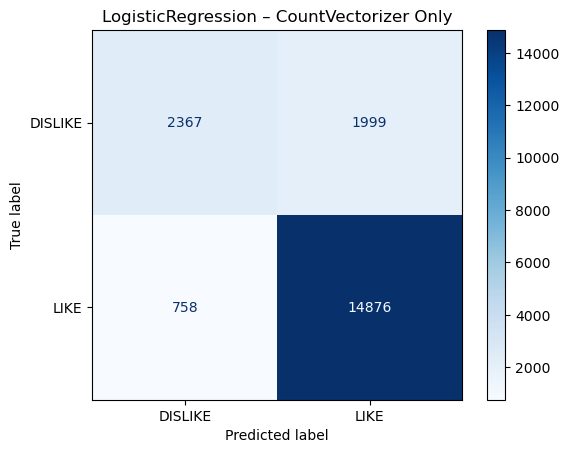


Training RandomForest (CountVectorizer Only)
Test Accuracy (RandomForest, CountVectorizer Only): 0.8740
Best Params: {'model__max_depth': None, 'model__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

     DISLIKE       0.85      0.52      0.64      4366
        LIKE       0.88      0.97      0.92     15634

    accuracy                           0.87     20000
   macro avg       0.86      0.75      0.78     20000
weighted avg       0.87      0.87      0.86     20000



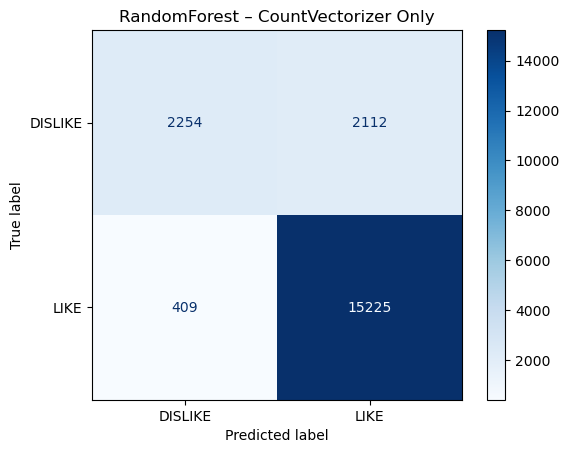


=== Running: CountVectorizer + Engineered ===

Training LogisticRegression (CountVectorizer + Engineered)
Test Accuracy (LogisticRegression, CountVectorizer + Engineered): 0.8630
Best Params: {'model__C': 1, 'model__solver': 'lbfgs'}
Classification Report:
               precision    recall  f1-score   support

     DISLIKE       0.75      0.56      0.64      4366
        LIKE       0.89      0.95      0.92     15634

    accuracy                           0.86     20000
   macro avg       0.82      0.75      0.78     20000
weighted avg       0.86      0.86      0.86     20000



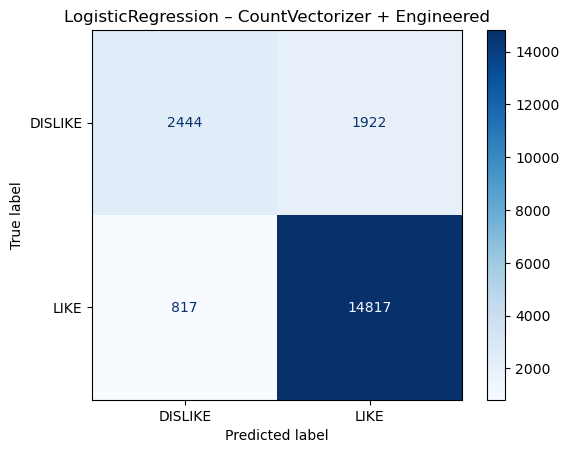


Training RandomForest (CountVectorizer + Engineered)
Test Accuracy (RandomForest, CountVectorizer + Engineered): 0.8689
Best Params: {'model__max_depth': None, 'model__n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

     DISLIKE       0.86      0.48      0.61      4366
        LIKE       0.87      0.98      0.92     15634

    accuracy                           0.87     20000
   macro avg       0.87      0.73      0.77     20000
weighted avg       0.87      0.87      0.85     20000



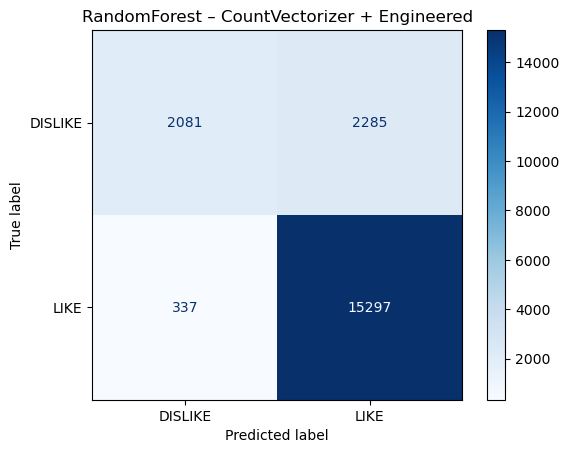

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("text_features_full.csv")
df = df.sample(n=100000, random_state=42)
df['Label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

# Splits
X_text = df['Text'].astype(str)
X_engineered = df[[
    'TextLengthWords',
    'NumUppercaseWords',
    'AvgWordLength',
    'ContainsNegation',
    'TextToSummaryRatio',
    'NumExclamations'
]]
y = df['Label']
X_text_train, X_text_test, X_eng_train, X_eng_test, y_train, y_test = train_test_split(
    X_text, X_engineered, y, test_size=0.2, stratify=y, random_state=42
)

# Define vectorizer and scaler pipelines
text_transformer = Pipeline([
    ('vect', CountVectorizer(stop_words='english', max_features=1000))
])
engineered_transformer = Pipeline([
    ('scale', StandardScaler())
])

# Modellen en grids
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'model__C': [0.01, 0.1, 1, 10],
            'model__solver': ['lbfgs', 'saga'],
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'model__n_estimators': [50, 100],
            'model__max_depth': [5, 10, None]
        }
    }
}

# Define engineered feature columns
engineered_features = [
    'TextLengthWords',
    'NumUppercaseWords',
    'AvgWordLength',
    'ContainsNegation',
    'TextToSummaryRatio',
    'NumExclamations'
]

for include_engineered in [False, True]:
    mode = "CountVectorizer Only" if not include_engineered else "CountVectorizer + Engineered"
    print(f"\n=== Running: {mode} ===")

    if include_engineered:
        preprocessor = ColumnTransformer([
            ('text', text_transformer, 'Text'),
            ('engineered', engineered_transformer, engineered_features)
        ])
        X_combined = df[['Text'] + engineered_features]
        X_train, X_test, y_train_local, y_test_local = train_test_split(
            X_combined, y, test_size=0.2, stratify=y, random_state=42
        )
    else:
        preprocessor = ColumnTransformer([
            ('text', text_transformer, 'Text')
        ])
        X_combined = df[['Text']]
        X_train, X_test, y_train_local, y_test_local = train_test_split(
            X_combined, y, test_size=0.2, stratify=y, random_state=42
        )

    for name, cfg in models.items():
        print(f"\nTraining {name} ({mode})")
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', cfg['model'])
        ])
        grid = GridSearchCV(pipe, cfg['params'], scoring='accuracy', cv=5, n_jobs=-1)
        grid.fit(X_train, y_train_local)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test_local, y_pred)

        print(f"Test Accuracy ({name}, {mode}): {acc:.4f}")
        print("Best Params:", grid.best_params_)
        print("Classification Report:\n", classification_report(y_test_local, y_pred, target_names=['DISLIKE', 'LIKE']))

        cm = confusion_matrix(y_test_local, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DISLIKE', 'LIKE'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"{name} – {mode}")
        plt.show()